In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DataPrep').getOrCreate()

In [2]:
Virus = spark.read.csv("Data/typeVirus.csv", header=True, inferSchema=True)
Flu = spark.read.csv("Data/FluView.csv", header=True, inferSchema=True,sep = ';')


In [3]:
from pyspark.sql.functions import count
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

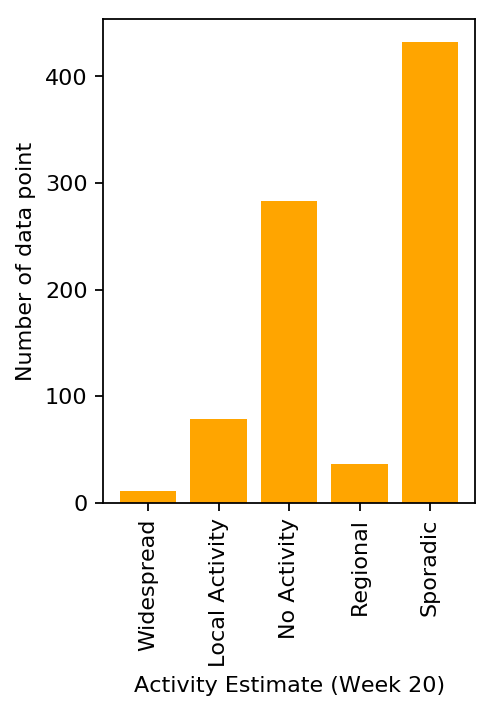

In [4]:
Flu20 = Flu.filter("WEEK == 20")
Flu20 = Flu20.groupBy("ACTIVITYESTIMATE").count().withColumnRenamed('count', 'Ndata')

Flu20 = Flu20.toPandas()

figure(num=None, figsize=(3, 4), dpi=160, facecolor='w', edgecolor='k')

plt.bar(np.array(np.array(Flu20['ACTIVITYESTIMATE'])), Flu20['Ndata'],color='orange')
plt.xlabel('Activity Estimate (Week 20)')
plt.ylabel('Number of data point')
plt.xticks(np.array(Flu20['ACTIVITYESTIMATE']),rotation=90)
plt.show()

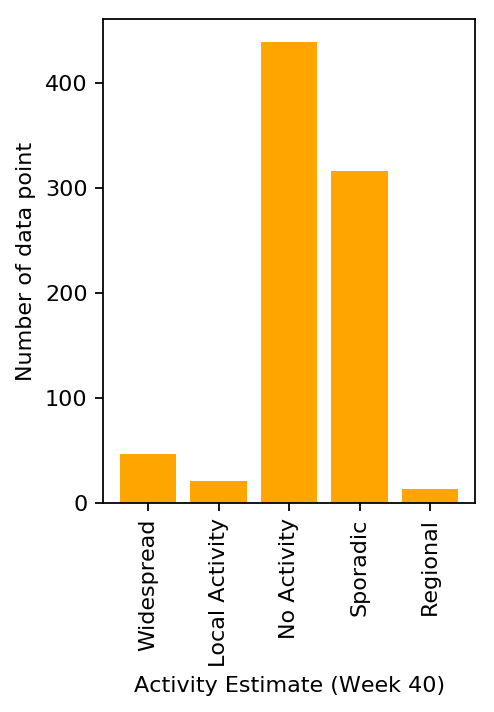

In [5]:
Flu40 = Flu.filter("WEEK == 40")
Flu40 = Flu40.groupBy("ACTIVITYESTIMATE").count().withColumnRenamed('count', 'Ndata')

Flu40 = Flu40.toPandas()

figure(num=None, figsize=(3, 4), dpi=160, facecolor='w', edgecolor='k')

plt.bar(np.array(np.array(Flu40['ACTIVITYESTIMATE'])), Flu40['Ndata'],color='orange')
plt.xlabel('Activity Estimate (Week 40)')
plt.ylabel('Number of data point')
plt.xticks(np.array(Flu40['ACTIVITYESTIMATE']),rotation=90)
plt.show()

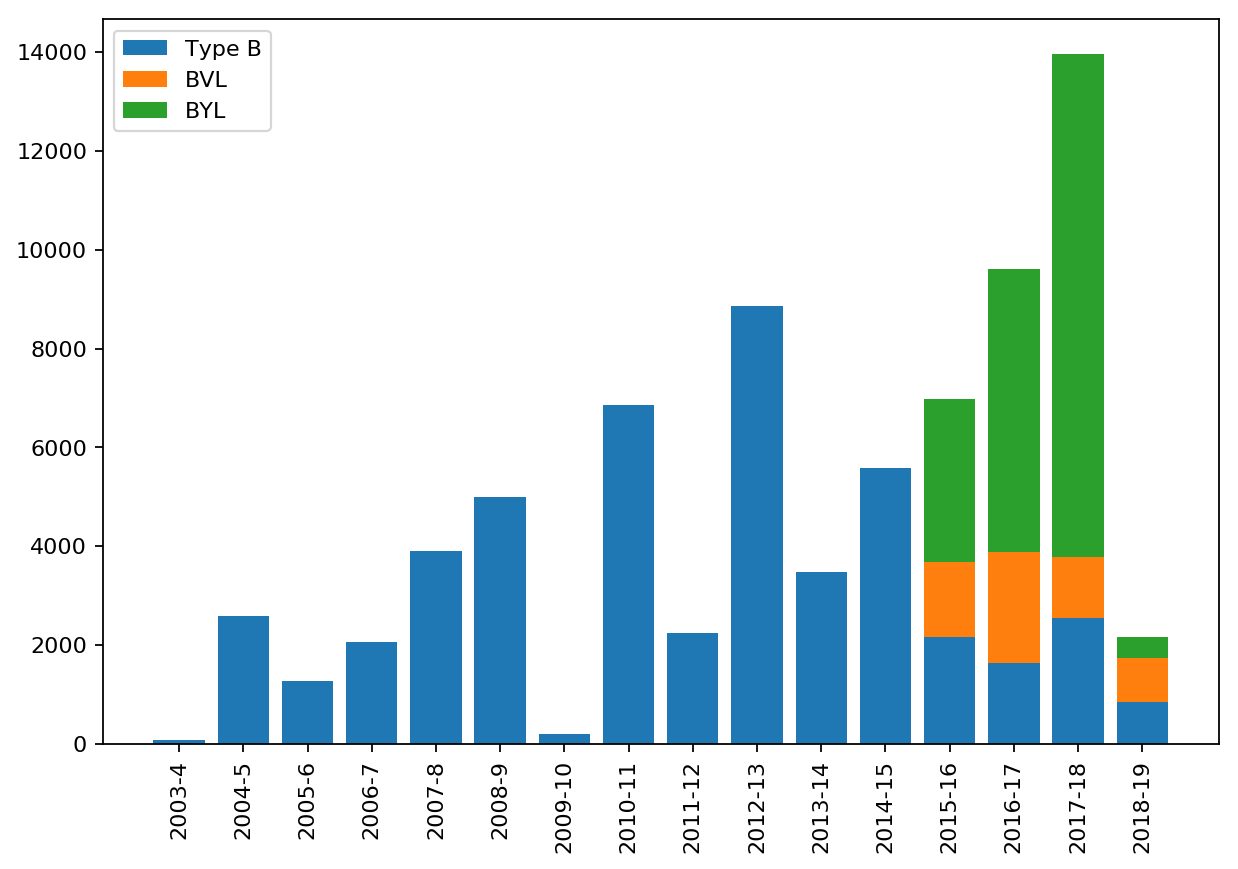

In [6]:
Virus = Virus.withColumn('AH1N1',Virus['AH1N1'].cast('integer'))
Virus = Virus.withColumn('BVL',Virus['BVL'].cast('integer'))
Virus = Virus.withColumn('BYL',Virus['BYL'].cast('integer'))
VirusSeason = Virus.select('SEASON','B','BVL','BYL').groupBy("SEASON").sum().select(['SEASON','sum(B)','sum(BVL)','sum(BYL)'])
VirusSeason = VirusSeason.na.fill(0)

VirusSeason = VirusSeason.toPandas().sort_values(by = 'SEASON')
VirusSeason

figure(num=None, figsize=(9, 6), dpi=160, facecolor='w', edgecolor='k')

data = [VirusSeason['sum(B)'],VirusSeason['sum(BVL)'],VirusSeason['sum(BYL)']]
y_offset = np.zeros(len(VirusSeason['SEASON']))
p=[]
ind = np.arange(len(VirusSeason['SEASON']))
for row in range(0,3):
    #print(row)
    #print(( data[row]))
    p.append(plt.bar(ind, data[row], bottom=y_offset))
    y_offset = y_offset + data[row]

plt.xticks(ind,np.array(VirusSeason['SEASON']),rotation=90)
#plt.yticks(np.arange(0, 860, 100))
plt.legend((p[0][0], p[1][0],p[2][0]), ('Type B', 'BVL','BYL'))
plt.show()    

In [7]:
Flu = Flu.filter('(WEEK <=20) or (WEEK >= 40)')
Flu = Flu.select(['STATENAME','ACTIVITYESTIMATE','WEEK','SEASON'])
Flu.printSchema()

root
 |-- STATENAME: string (nullable = true)
 |-- ACTIVITYESTIMATE: string (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- SEASON: string (nullable = true)



In [8]:
Virus = spark.read.csv("Data/typeVirus.csv", header=True, inferSchema=True)
Virus = Virus.withColumn('AH1N1',Virus['AH1N1'].cast('integer'))
Virus = Virus.withColumn('BVL',Virus['BVL'].cast('integer'))
Virus = Virus.withColumn('BYL',Virus['BYL'].cast('integer'))

#Virus.describe().show()



Virus = Virus.withColumnRenamed('AH3', 'TypeA_subH3')
Virus = Virus.withColumnRenamed('AH1N1', 'TypeA_subH1N1')
Virus = Virus.withColumnRenamed('A', 'TypeA')
Virus = Virus.withColumnRenamed('AU', 'TypeA_subU')
Virus = Virus.withColumnRenamed('AH1', 'TypeA_subH1')
Virus = Virus.withColumnRenamed('H3N2', 'TypeA_subH3N2')
Virus = Virus.withColumnRenamed('B', 'TypeB')
Virus = Virus.withColumnRenamed('BVL', 'TypeB_subVL')
Virus = Virus.withColumnRenamed('BYL', 'TypeB_subYL')

Virus = Virus.withColumn('B',Virus['TypeB']+Virus['TypeB_subYL']+Virus['TypeB_subVL'])

Virus = Virus.drop('TypeB_subVL')
Virus = Virus.drop('TypeB_subYL')
Virus = Virus.drop('_c0')
Virus = Virus.drop('TypeB')
Virus = Virus.withColumnRenamed('B', 'TypeB')
Virus = Virus.na.fill(0, subset=['TypeB'])

Virus.printSchema()

root
 |-- WEEK: integer (nullable = true)
 |-- SEASON: string (nullable = true)
 |-- TypeA_subH3: integer (nullable = true)
 |-- TypeA_subH1N1: integer (nullable = true)
 |-- TypeA: integer (nullable = true)
 |-- TypeA_subH3N2: integer (nullable = true)
 |-- TypeA_subU: integer (nullable = true)
 |-- TypeA_subH1: integer (nullable = true)
 |-- TypeB: integer (nullable = true)



In [9]:
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,FloatType)
data_schema_pop = [StructField('STATENAME',StringType(),True),
              StructField('POP',IntegerType(),True),
              StructField('SEASON',StringType(),True)]

final_struct_pop = StructType(fields=data_schema_pop)

Population = spark.read.format("csv").option("header", "true").option("delimiter", "\t").schema(final_struct_pop).load("Data/population.csv")

Population.printSchema()
Population.show(n=5)

root
 |-- STATENAME: string (nullable = true)
 |-- POP: integer (nullable = true)
 |-- SEASON: string (nullable = true)

+----------+--------+-------+
| STATENAME|     POP| SEASON|
+----------+--------+-------+
|   Alabama| 4503491|2003-04|
|    Alaska|  648414|2003-04|
|   Arizona| 5510364|2003-04|
|  Arkansas| 2724816|2003-04|
|California|35253159|2003-04|
+----------+--------+-------+
only showing top 5 rows



In [10]:
Health = spark.read.format("csv").option("header", "true").option("delimiter", ";").load("Data/HealthCare.csv")

from pyspark.sql.functions import *
Health = Health.withColumn('65 years and over',regexp_replace('65 years and over', ',', '.').cast('float'))
Health = Health.withColumn('Under 65 years',regexp_replace('Under 65 years', ',', '.').cast('float'))
Health = Health.withColumn('Under 18 years',regexp_replace('Under 18 years', ',', '.').cast('float'))
Health = Health.withColumn('All persons',regexp_replace('All persons', ',', '.').cast('float'))

Health.printSchema()

Health = Health.withColumnRenamed('All persons', 'HealthCare_All')
Health = Health.withColumnRenamed('Under 65 years', 'HealthCare_Under65')
Health = Health.withColumnRenamed('Under 18 years', 'HealthCare_Under18')
Health = Health.withColumnRenamed('65 years and over', 'HealthCare_Over65')

Health.show(n=5)

root
 |-- STATENAME: string (nullable = true)
 |-- All persons: float (nullable = true)
 |-- Under 65 years: float (nullable = true)
 |-- Under 18 years: float (nullable = true)
 |-- 65 years and over: float (nullable = true)

+----------+--------------+------------------+------------------+-----------------+
| STATENAME|HealthCare_All|HealthCare_Under65|HealthCare_Under18|HealthCare_Over65|
+----------+--------------+------------------+------------------+-----------------+
|   Alabama|          84.6|              82.3|              91.1|             98.5|
|    Alaska|          85.2|              82.9|              91.8|             99.8|
|   Arizona|          81.0|              79.3|              83.5|             96.5|
|  Arkansas|          82.0|              79.3|              86.3|             97.3|
|California|          81.6|              78.6|              91.7|             98.0|
+----------+--------------+------------------+------------------+-----------------+
only showing top 

In [11]:
data_schema_income = [StructField('_c0',StringType(),True),
              StructField('STATENAME',StringType(),True),
              StructField('INCOME',IntegerType(),True),
              StructField('SEASON',StringType(),True)]

final_struct_income = StructType(fields=data_schema_income)

Income = spark.read.format("csv").option("header", "true").schema(final_struct_income).load("Data/Income.csv") 
Income = Income.drop('_c0')
Income.printSchema()
Income.show(n=5) 

root
 |-- STATENAME: string (nullable = true)
 |-- INCOME: integer (nullable = true)
 |-- SEASON: string (nullable = true)

+----------+------+-------+
| STATENAME|INCOME| SEASON|
+----------+------+-------+
|   Alabama| 51113|2017-18|
|    Alaska| 72231|2017-18|
|   Arizona| 61125|2017-18|
|  Arkansas| 48829|2017-18|
|California| 69759|2017-18|
+----------+------+-------+
only showing top 5 rows



In [12]:
data_schema_Area = [StructField('STATENAME',StringType(),True),
              StructField('AREA',IntegerType(),True)]

final_struct_Area = StructType(fields=data_schema_Area)

Area = spark.read.format("csv").option("header", "true").option("delimiter", "\t").schema(final_struct_Area).load("Data/Area.csv") 

Area.printSchema()
Area.show(n=5) 

root
 |-- STATENAME: string (nullable = true)
 |-- AREA: integer (nullable = true)

+----------+-------+
| STATENAME|   AREA|
+----------+-------+
|   Alabama| 135767|
|    Alaska|1723337|
|   Arizona| 295234|
|  Arkansas| 137732|
|California| 423967|
+----------+-------+
only showing top 5 rows



# Merging

In [13]:
traintest = Flu.join(Population, (Flu.SEASON == Population.SEASON) & (Flu.STATENAME == Population.STATENAME) ).drop(Population.STATENAME).drop(Population.SEASON)
traintest = traintest.join(Area,(traintest.STATENAME == Area.STATENAME) ).drop(Area.STATENAME)
traintest = traintest.join(Health, (traintest.STATENAME == Health.STATENAME) ).drop(Health.STATENAME)
traintest = traintest.join(Income, (traintest.SEASON == Income.SEASON) & (traintest.STATENAME == Income.STATENAME) ).drop(Income.STATENAME).drop(Income.SEASON)
traintest = traintest.join(Virus, (traintest.SEASON == Virus.SEASON) & (traintest.WEEK == Virus.WEEK)).drop(Virus.WEEK).drop(Virus.SEASON)

traintest.show(5)

+---------+----------------+----+-------+-------+------+--------------+------------------+------------------+-----------------+------+-----------+-------------+-----+-------------+----------+-----------+-----+
|STATENAME|ACTIVITYESTIMATE|WEEK| SEASON|    POP|  AREA|HealthCare_All|HealthCare_Under65|HealthCare_Under18|HealthCare_Over65|INCOME|TypeA_subH3|TypeA_subH1N1|TypeA|TypeA_subH3N2|TypeA_subU|TypeA_subH1|TypeB|
+---------+----------------+----+-------+-------+------+--------------+------------------+------------------+-----------------+------+-----------+-------------+-----+-------------+----------+-----------+-----+
|  Alabama|      Widespread|  40|2009-10|4757938|135767|          84.6|              82.3|              91.1|             98.5| 39980|         11|         1603|   64|            0|        17|          9|    0|
|  Alabama|      Widespread|  41|2009-10|4757938|135767|          84.6|              82.3|              91.1|             98.5| 39980|          5|         1877|

In [14]:
traintest.printSchema()
traintest.toPandas().to_csv('traintest.csv')

root
 |-- STATENAME: string (nullable = true)
 |-- ACTIVITYESTIMATE: string (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- SEASON: string (nullable = true)
 |-- POP: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- HealthCare_All: float (nullable = true)
 |-- HealthCare_Under65: float (nullable = true)
 |-- HealthCare_Under18: float (nullable = true)
 |-- HealthCare_Over65: float (nullable = true)
 |-- INCOME: integer (nullable = true)
 |-- TypeA_subH3: integer (nullable = true)
 |-- TypeA_subH1N1: integer (nullable = true)
 |-- TypeA: integer (nullable = true)
 |-- TypeA_subH3N2: integer (nullable = true)
 |-- TypeA_subU: integer (nullable = true)
 |-- TypeA_subH1: integer (nullable = true)
 |-- TypeB: integer (nullable = true)



# Feature Creation

### PrevWeek

In [15]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

traintest = spark.read.csv("traintest.csv", header=True, inferSchema=True)

w = Window().partitionBy().orderBy(col("_c0"))
traintest = traintest.select("*", lag("ACTIVITYESTIMATE").over(w).alias("PrevWeek"))#.na.drop()
# supprimer week 40
traintest = traintest.filter("WEEK != 40").select('*')

### number of states that was in each activity class during the previous week. This new feature are named NRegional, NLocalAct, NSporadic, NWidespread.


In [16]:
from pyspark.sql.functions import count

CSpo = traintest.where(traintest.PrevWeek=="Sporadic").groupBy("SEASON","WEEK").count().withColumnRenamed('count', 'NSporadic').withColumnRenamed('SEASON', 'SEASON2').withColumnRenamed('WEEK', 'WEEK2')
CLoc = traintest.where(traintest.PrevWeek=="Local Activity").groupBy("SEASON","WEEK").count().withColumnRenamed('count', 'NLocalAct').withColumnRenamed('SEASON', 'SEASON2').withColumnRenamed('WEEK', 'WEEK2')
CNoAct = traintest.where(traintest.PrevWeek=="No Activity").groupBy("SEASON","WEEK").count().withColumnRenamed('count', 'NNoAct').withColumnRenamed('SEASON', 'SEASON2').withColumnRenamed('WEEK', 'WEEK2')
CReg = traintest.where(traintest.PrevWeek=="Regional").groupBy("SEASON","WEEK").count().withColumnRenamed('count', 'NRegional').withColumnRenamed('SEASON', 'SEASON2').withColumnRenamed('WEEK', 'WEEK2')
CWide = traintest.where(traintest.PrevWeek=="Widespread").groupBy("SEASON","WEEK").count().withColumnRenamed('count', 'NWidespread').withColumnRenamed('SEASON', 'SEASON2').withColumnRenamed('WEEK', 'WEEK2')

traintest = traintest.join(CSpo,(traintest.SEASON == CSpo.SEASON2) &  (traintest.WEEK == CSpo.WEEK2),how = 'left').drop(CSpo.SEASON2).drop(CSpo.WEEK2)
traintest = traintest.join(CLoc,(traintest.SEASON == CLoc.SEASON2) &  (traintest.WEEK == CLoc.WEEK2),how = 'left').drop(CLoc.SEASON2).drop(CLoc.WEEK2)
traintest = traintest.join(CNoAct,(traintest.SEASON == CNoAct.SEASON2) &  (traintest.WEEK == CNoAct.WEEK2),how = 'left').drop(CNoAct.SEASON2).drop(CNoAct.WEEK2)
traintest = traintest.join(CReg,(traintest.SEASON == CReg.SEASON2) &  (traintest.WEEK == CReg.WEEK2),how = 'left').drop(CReg.SEASON2).drop(CReg.WEEK2)
traintest = traintest.join(CWide,(traintest.SEASON == CWide.SEASON2) &  (traintest.WEEK == CWide.WEEK2),how = 'left').drop(CWide.SEASON2).drop(CWide.WEEK2)

In [17]:
traintest = traintest.na.drop(subset="PrevWeek")
traintest = traintest.na.fill(0)

In [19]:
traintest.show(5)

+---+---------+----------------+-----------+----+-------+-------+------+----------------+------------------+------------------+-----------------+------+-----------+-------------+-----+-------------+----------+-----------+-----+----------+---------+---------+------+---------+-----------+
|_c0|STATENAME|ACTIVITYESTIMATE|    WEEKEND|WEEK| SEASON|    POP|  AREA|  HealthCare_All|HealthCare_Under65|HealthCare_Under18|HealthCare_Over65|INCOME|TypeA_subH3|TypeA_subH1N1|TypeA|TypeA_subH3N2|TypeA_subU|TypeA_subH1|TypeB|  PrevWeek|NSporadic|NLocalAct|NNoAct|NRegional|NWidespread|
+---+---------+----------------+-----------+----+-------+-------+------+----------------+------------------+------------------+-----------------+------+-----------+-------------+-----+-------------+----------+-----------+-----+----------+---------+---------+------+---------+-----------+
|  1|  Alabama|      Widespread|Oct-17-2009|  41|2009-10|4757938|135767|84.5999984741211| 82.30000305175781|  91.0999984741211|         

In [18]:
traintest.drop('_c0').toPandas().to_csv('traintest.csv')

In [19]:
traintest = spark.read.csv("traintest.csv", header=True, inferSchema=True)
traintest.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- STATENAME: string (nullable = true)
 |-- ACTIVITYESTIMATE: string (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- SEASON: string (nullable = true)
 |-- POP: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- HealthCare_All: double (nullable = true)
 |-- HealthCare_Under65: double (nullable = true)
 |-- HealthCare_Under18: double (nullable = true)
 |-- HealthCare_Over65: double (nullable = true)
 |-- INCOME: integer (nullable = true)
 |-- TypeA_subH3: integer (nullable = true)
 |-- TypeA_subH1N1: integer (nullable = true)
 |-- TypeA: integer (nullable = true)
 |-- TypeA_subH3N2: integer (nullable = true)
 |-- TypeA_subU: integer (nullable = true)
 |-- TypeA_subH1: integer (nullable = true)
 |-- TypeB: integer (nullable = true)
 |-- PrevWeek: string (nullable = true)
 |-- NSporadic: integer (nullable = true)
 |-- NLocalAct: integer (nullable = true)
 |-- NNoAct: integer (nullable = true)
 |-- NRegional: integer (n